# BI-PRS - Semestral work 2 (samarrik's version)

## Dataset selection according to the represant's data

In [190]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> ex0327, Life, P. Novák')

Parameter M = 2 => ex0327, Life, P. Novák

## Necessary imports

In [191]:
# TODO: manage imports
library(Sleuth2)
library(ggplot2)
library(olsrr)
library(psych)
library(car)

## Data preparation

* Download the dataset.
* Explore, describe and modify the data if needed.

In [192]:
str(ex0327)
data <- ex0327
head(data, 5)

'data.frame':	29 obs. of  4 variables:
 $ Country: chr  "Australia" "Austria" "Belgium" "Canada" ...
 $ Life   : num  71 70.4 70.6 72 73.3 ...
 $ Income : num  3426 3350 3346 4751 5029 ...
 $ Type   : Factor w/ 2 levels "Industrialized",..: 1 1 1 1 1 1 1 1 1 1 ...


,Country,Life,Income,Type
,<chr>,<dbl>,<dbl>,<fct>
1,Australia,71.0,3426,Industrialized
2,Austria,70.4,3350,Industrialized
3,Belgium,70.6,3346,Industrialized
4,Canada,72.0,4751,Industrialized
5,Denmark,73.3,5029,Industrialized


The dataset contains data about life expectancy and *per capita income*\*  for 20 *industrialized countries*\** and 9 *petroleum exporting countries*\***. 

A data frame with 29 observations on the following 4 variables.
<br> `Country` : a character vector indicating the country
<br> `Life` : a character vector indicating the country
<br> `Income` : income in 1974 (U.S. dollars)
<br> `Type` : factor variable with levels "Industrialized" and "Petroleum"
<br> [1]

\* - **Per capita income**: measures the average income earned per person in a given area (city, region, country, etc.) in a specified year. [2] 
<br> \** - **Industrialized countries**: Countries whose gross domestic product and exports contain a large share of industrial production. [3]
<br> \*** - **Petroleum exporting countries**: The writer probably has meant the countries of The Organization of the Petroleum Exporting Countries (OPEC) [4]

### Modifying the data
Due to the small number of regressors the additional one `Government` will be derived from the existing `Country`. This is a categorical feature that describes governance models of the countries provided. The feature has $3$ categories: `Parliamentary or constitutional monarchy`, `Republic`, `Authoritarian/one-party regimes`

In [193]:
data$Government <- c(1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3)
data$Government <- factor(
  data$Government, levels=c(1, 2, 3),
  labels=c('Parliamentary or constitutional monarchy', 'Republic', 'Authoritarian/one-party regimes'),)
head(data, 3)

,Country,Life,Income,Type,Government
,<chr>,<dbl>,<dbl>,<fct>,<fct>
1,Australia,71.0,3426,Industrialized,Parliamentary or constitutional monarchy
2,Austria,70.4,3350,Industrialized,Republic
3,Belgium,70.6,3346,Industrialized,Parliamentary or constitutional monarchy


### Data exploration

The following are summaries for both continuous and factor features.

In [194]:
continous_cols <- c('Life', 'Income')
factor_cols <- c('Type', 'Government')
describe(data[continous_cols], skew=F, ranges=F, quant=c(0.25, 0.75), IQR=T)[, -1]

,n,mean,sd,se,IQR,Q0.25,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Life,29,64.800,11.09298,2.059915,19.70,52.3,72.00
Income,28,2765.179,1684.11408,318.267645,2547.75,1270.0,3817.75


In [195]:
summary(data[factor_cols])

             Type                                       Government
 Industrialized:20   Parliamentary or constitutional monarchy: 9  
 Petroleum     : 9   Republic                                :10  
                     Authoritarian/one-party regimes         :10  

As it is mentioned in the original dataset description, the only `NaN` value is the income in South Africa. [1] For the purpose of training of models, the `clean_data` version of the dataset will be created.

In [196]:
clean_data <- data[!is.na(data$Income),]

### Data visualization

The following graph shows the visual difference in the life expectancy between `Industrialised` and `Petroleum` countries.

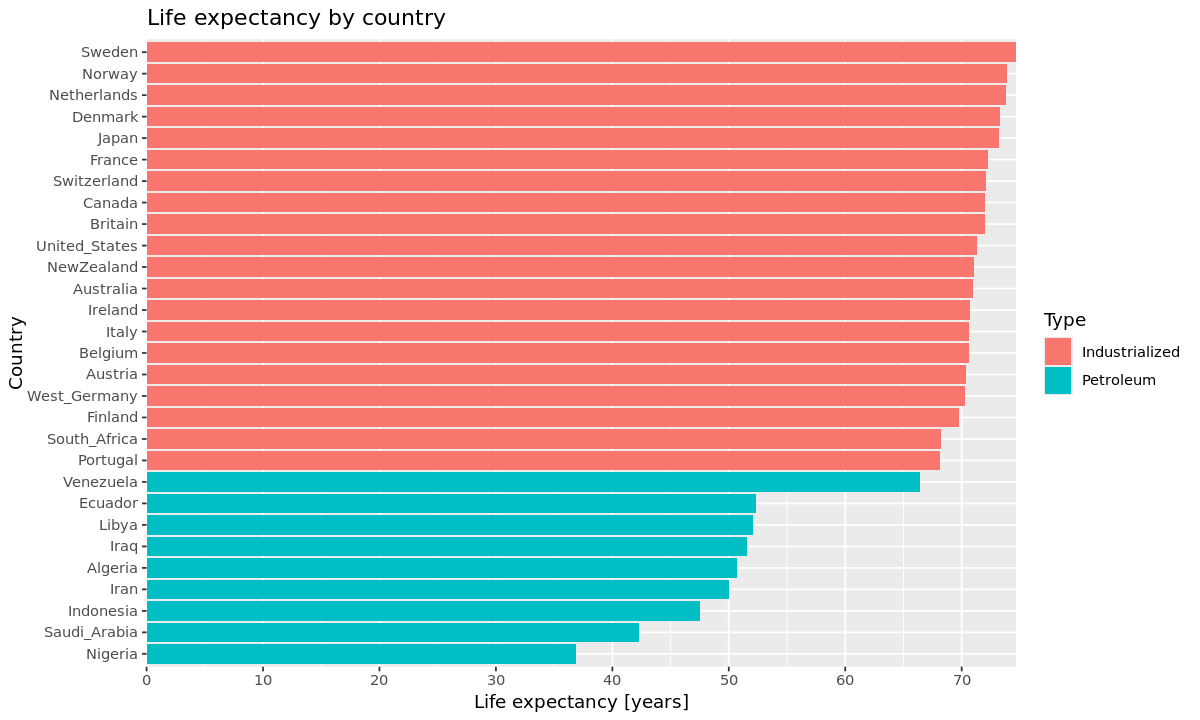

In [197]:
options(repr.plot.width=10, repr.plot.height=6) # set the size of a plot
ggplot(data, aes(x=Life, y=reorder(Country, Life), fill=Type)) +
    geom_bar(stat='identity') +
    labs(title='Life expectancy by country',
         x='Life expectancy [years]',
         y='Country') +
    scale_x_continuous(breaks=scales::pretty_breaks(n=10), expand=c(0, 0))

The obervation the draws the attention of a reader immediately is the difference in the expectation value of the variable `Life` between the types of the countries. We see that `Industrialised` countries have a dominative `Life expectancy` in comparison to `Petroleum` countries. To test the described heterogeneity an **ANOVA** is being conducted later in the work.

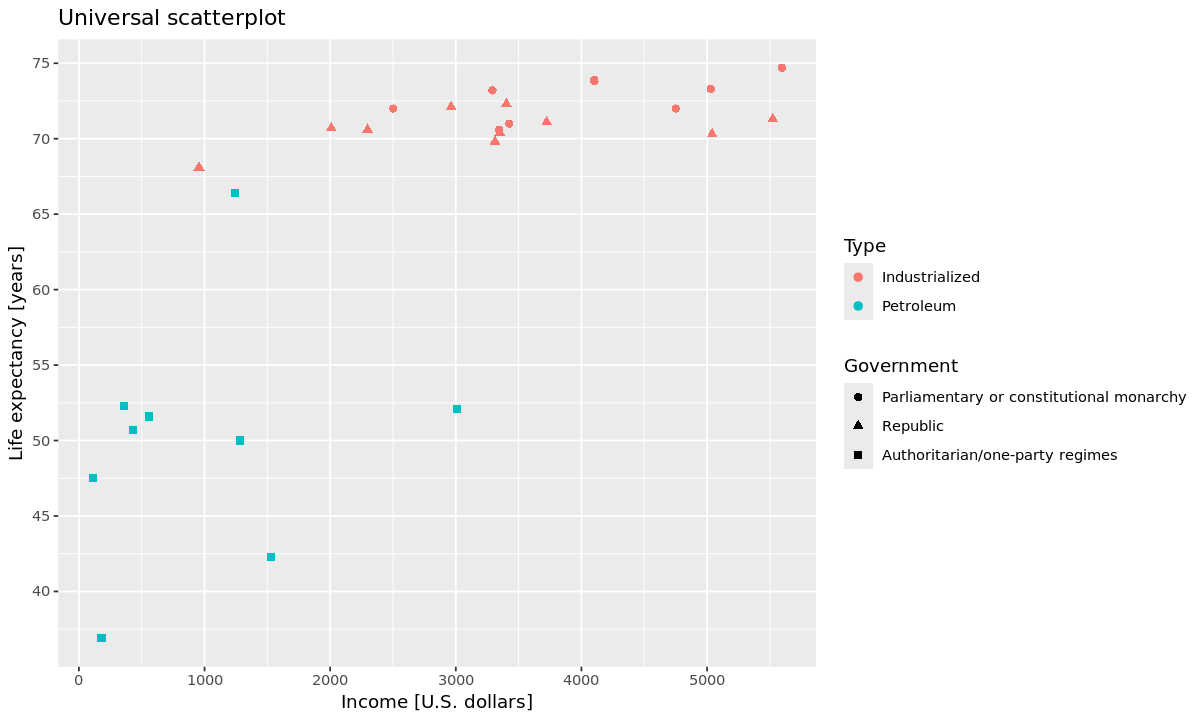

In [198]:
scatterplot <- ggplot(clean_data, aes(x=Income, y=Life, col=Type, shape=Government)) +
    geom_point(size=2) +
    labs(title='Universal scatterplot',
         x='Income [U.S. dollars]',
         y='Life expectancy [years]') +
    scale_y_continuous(breaks=scales::pretty_breaks(n=6)) +
    scale_x_continuous(breaks=scales::pretty_breaks(n=6)) 
scatterplot

The scatterplot placed above visualizes a few paramount insights hidden in data:
* `Petroleum` countries not only have a shorter `Life expectancy` on average but they also have a lower `Income` on average. Clusters are clearly observable.
* **All** petroleum countries are `Authoritarian/one-party regimes`.

In [199]:
# TODO
industrialized.mean <- mean(data[data$Type == 'Industrialized', 'Life'])
industrialized.std <- sd(data[data$Type == 'Industrialized', 'Life'])
petroleum.std <- mean(data[data$Type == 'Petroleum', 'Life'])
petroleum.std <- sd(data[data$Type == 'Petroleum', 'Life'])

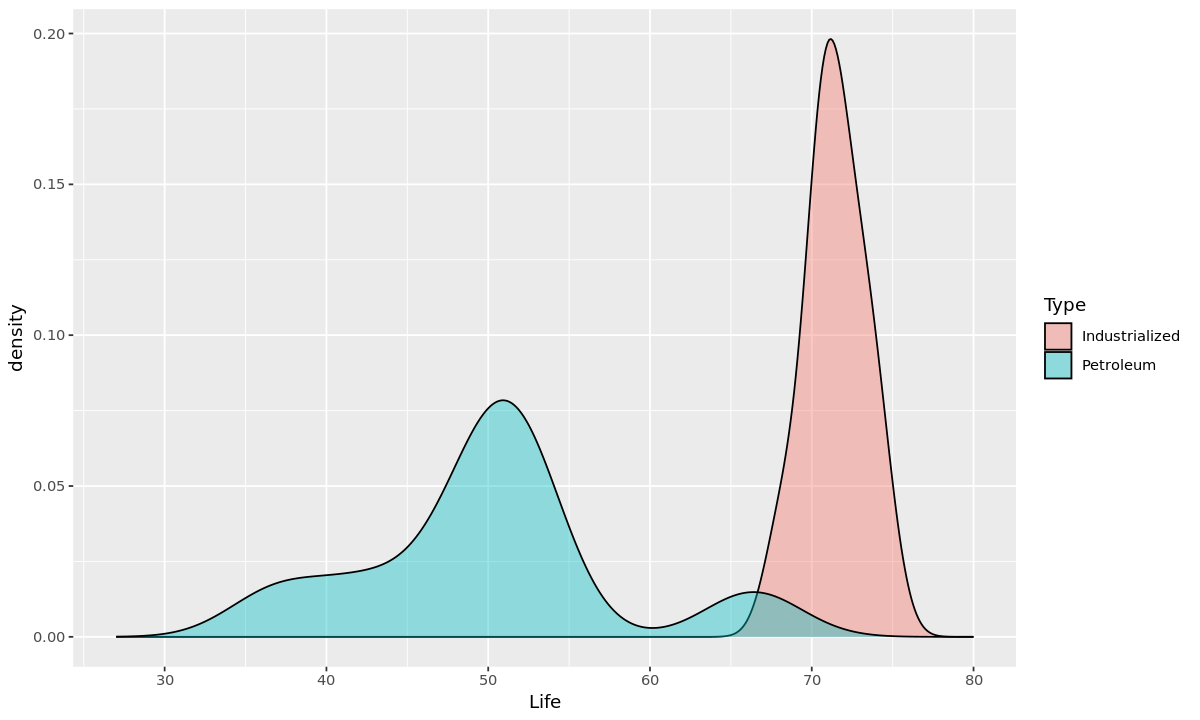

In [200]:
ggplot(data, aes(x=Life, fill=Type)) +
    geom_density(alpha=0.4, adjust=1.5) +
    scale_x_continuous(breaks=seq(30, 80, by=10), limits=c(27, 80))

The difference of the `Life expectancy` is being proven visually once more on the graph above.

### Analysis of a numerical regressor

The `Income` of a country is a selected categorical regressor. The $log()$ transformation is applied to the regressor.

In [201]:
fit <- lm(Life ~ log(Income), clean_data)
summary(fit)


Call:
lm(formula = Life ~ log(Income), data = clean_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.279  -1.288   1.175   3.875   9.573 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.598      9.458  -0.063     0.95    
log(Income)    8.615      1.237   6.966 2.14e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.787 on 26 degrees of freedom
Multiple R-squared:  0.6512,	Adjusted R-squared:  0.6377 
F-statistic: 48.53 on 1 and 26 DF,  p-value: 2.137e-07


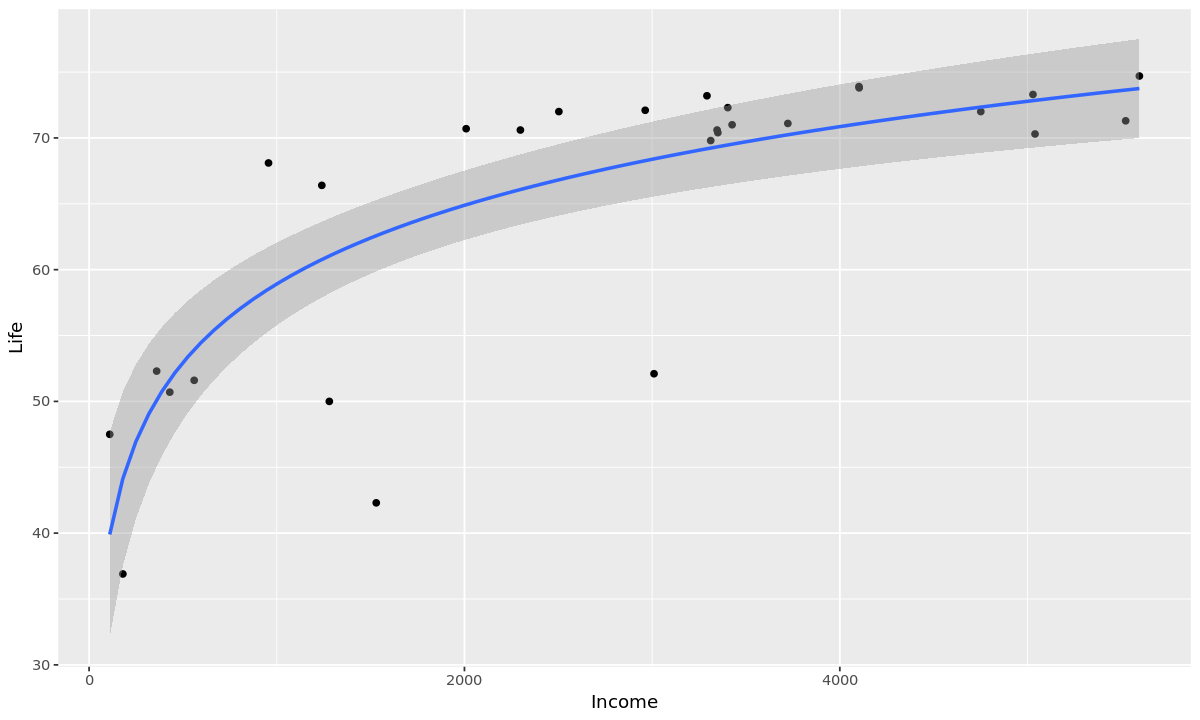

In [202]:
# TODO: comment
ggplot(clean_data, aes(x=Income, y=Life)) +
    geom_point() +
    geom_smooth(method='lm', formula=y ~ log(x))

As we can see, the logarithmic transformation is the most suitable one from the simplest for the given data.

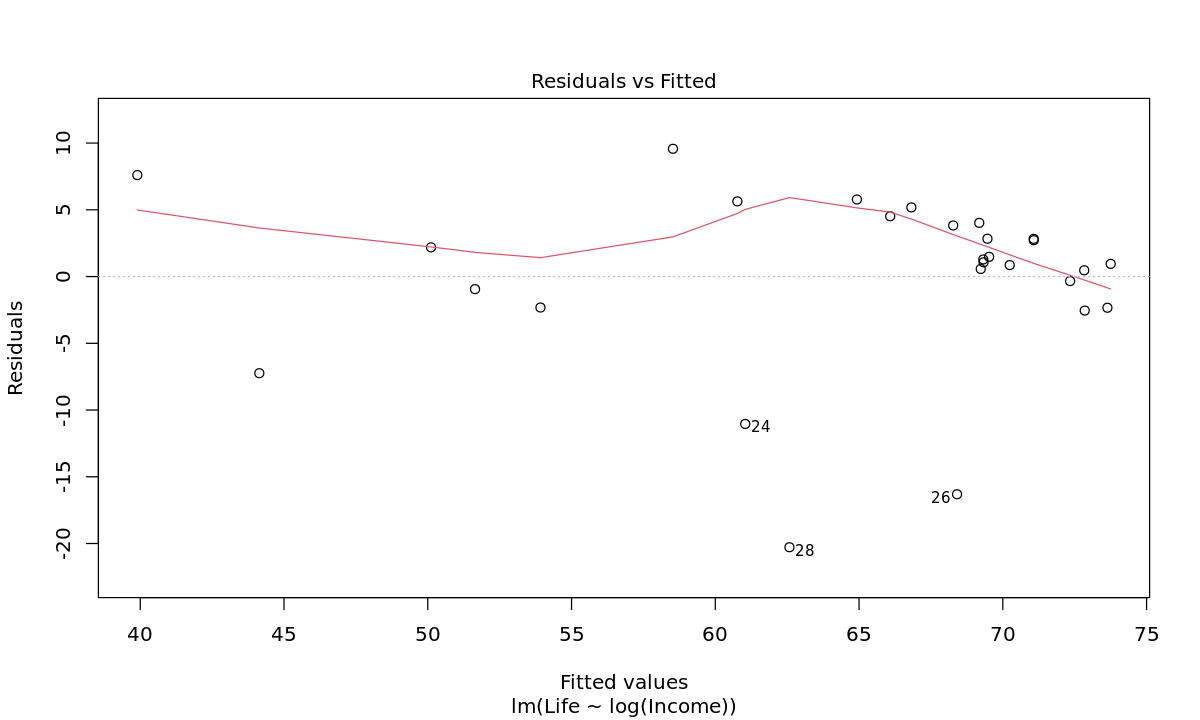

In [203]:
# TODO: comment
plot(fit, which=1)

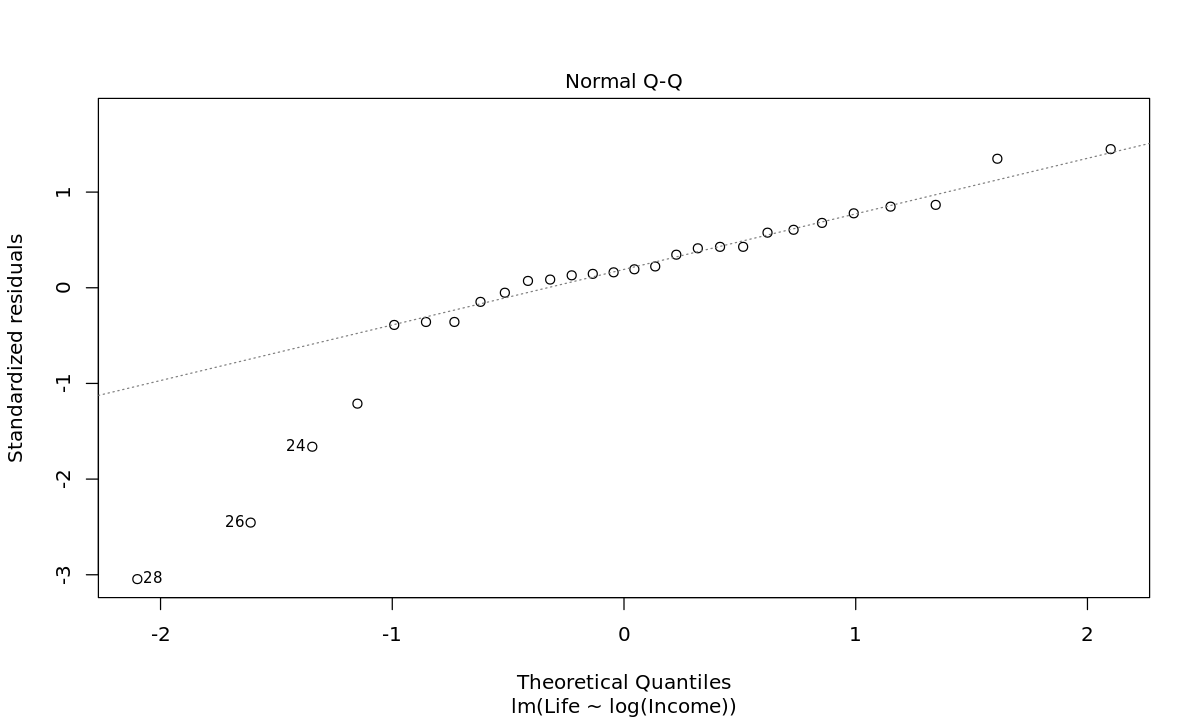

In [204]:
# TODO: comment
plot(fit, which=2)

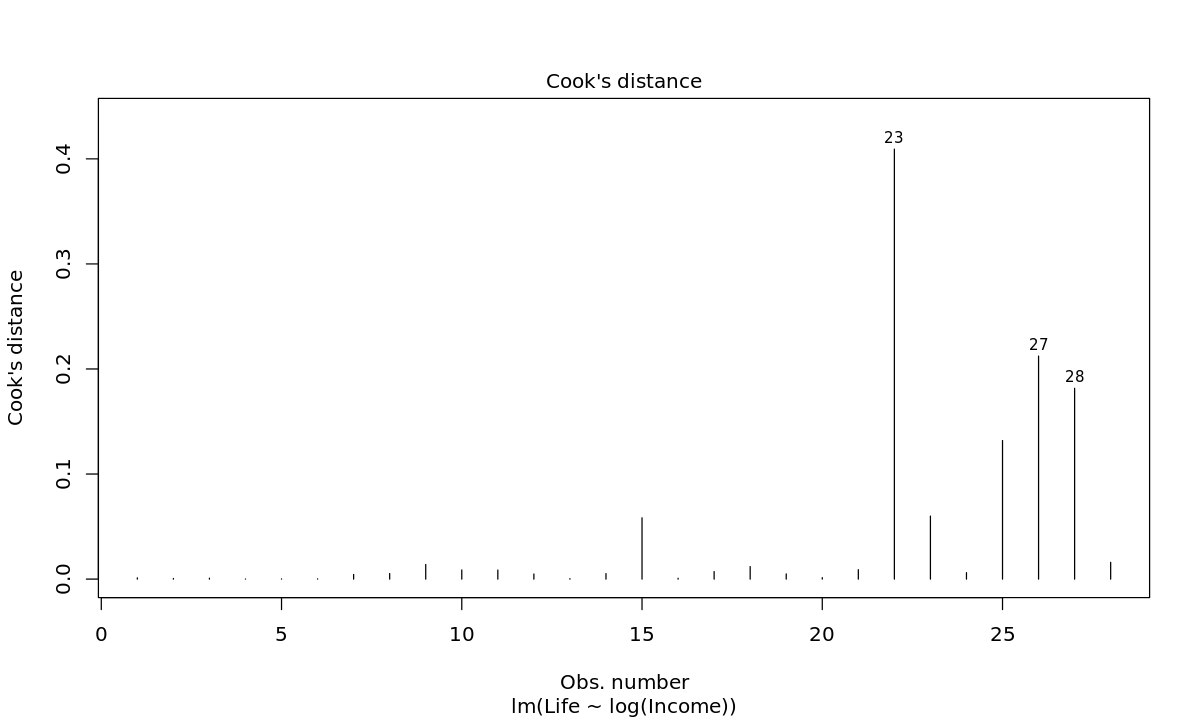

In [205]:
# TODO: comment
plot(fit, which=4)

### Analysis of a categorical regressor

The `Type` of a country is a selected categorical regressor.
<br> To analyse how this feature affects the target variable `life` the **ANOVA** is conducted.

$Industrialized
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  68.10   70.55   71.20   71.47   72.53   74.70 

$Petroleum
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  36.90   47.50   50.70   49.98   52.10   66.40 


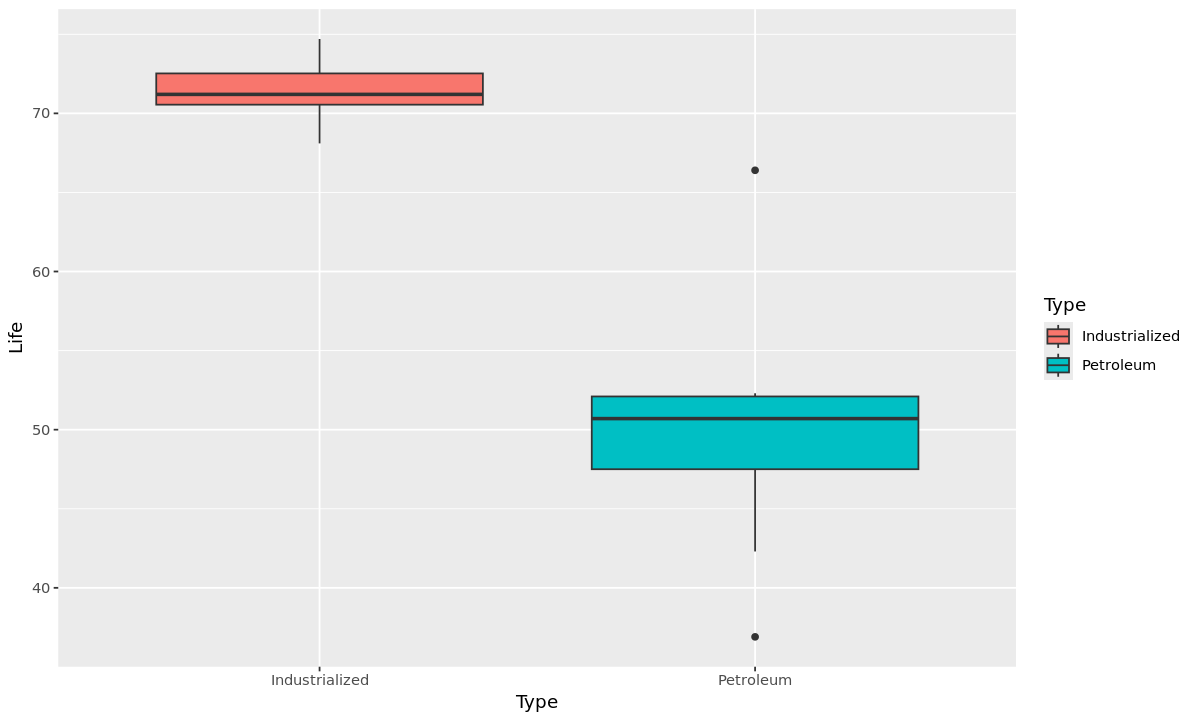

In [206]:
tapply(data$Life, data$Type, summary) # split the data$Life in groups by data$Type values and apply summary on it
ggplot(data, aes(x=Type, y=Life, fill=Type)) +
  geom_boxplot()

Using the `tapply` (tabulate apply) function the summary for the data of two categories was calculated. To make the difference in the **expected value** and the **variance** in the `Life expectancy` conditioned by the `Type` of a country even more visible, there is a boxplot placed above, which makes it obvious at a first glance. The intuition is tested below.

What is tested, formally:
<br>$𝐻0: 𝜇1 = 𝜇2$
<br>$𝐻𝐴: 𝜇1 ≠ 𝜇2$

In [207]:
aov(Life~Type, data)

Call:
   aov(formula = Life ~ Type, data = data)

Terms:
                     Type Residuals
Sum of Squares  2867.0625  578.4576
Deg. of Freedom         1        27

Residual standard error: 4.628645
Estimated effects may be unbalanced

In [208]:
anova(aov(Life~Type, data))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Type,1,2867.0625,2867.06249,133.8226,5.713448e-12
Residuals,27,578.4576,21.42436,NA,NA


The `aov()` shows us which part of the variability is described by the difference in types. Using the **F-value** calculated by `anova()` we can **reject the hypothesis** of equality of expected values of `Life` amongst the `Industrialized` and `Petroleum` countries in favor of the alternative hypothesis.

In [209]:
fit = lm(data$Life~data$Type)
summary(fit)


Call:
lm(formula = data$Life ~ data$Type)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.0778  -1.0700   0.0222   1.7300  16.4222 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          71.470      1.035   69.05  < 2e-16 ***
data$TypePetroleum  -21.492      1.858  -11.57 5.71e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.629 on 27 degrees of freedom
Multiple R-squared:  0.8321,	Adjusted R-squared:  0.8259 
F-statistic: 133.8 on 1 and 27 DF,  p-value: 5.713e-12


Suprisingly, `Type` describes the target variable quite accurately, having the $R^2\ score$ = $0.83$. We also see that the **t-test** of the nullity came out insignificant. That means that there's a significant difference of the mean values of `Life` amongst the categories.

We can interprete the results as following:
<br> ***"The average life expectancy in Petroleum countries is $21$ years less than the average life expectancy in Industrialized countries."***

### Analysis of both numerical and categorical regressor

In [210]:
summary(lm(data$Life~data$Type*data$Income))


Call:
lm(formula = data$Life ~ data$Type * data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.4145  -1.1530  -0.2627   1.6009  15.8443 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     6.887e+01  3.424e+00  20.115  < 2e-16 ***
data$TypePetroleum             -2.093e+01  4.135e+00  -5.062 3.55e-05 ***
data$Income                     7.673e-04  8.992e-04   0.853    0.402    
data$TypePetroleum:data$Income  1.347e-03  1.995e-03   0.675    0.506    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.658 on 24 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8483,	Adjusted R-squared:  0.8294 
F-statistic: 44.74 on 3 and 24 DF,  p-value: 5.545e-10


The following objects are masked from clean_data (pos = 3):

    Country, Government, Income, Life, Type




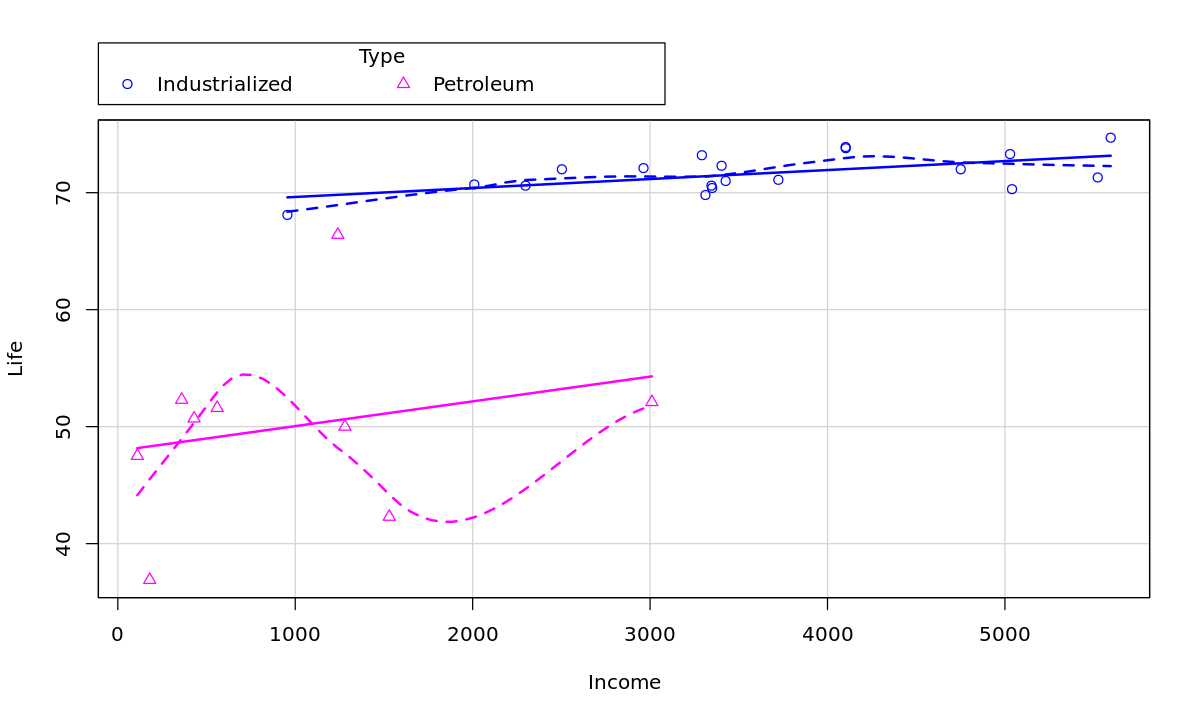

In [211]:
attach(clean_data)
scatterplot(Life ~ Income * Type)
detach(clean_data)

The key findings that need to be highlighted:
1. This is the best model at this very moment. $R^2 = 0.84$, which is a little better than the model dependent on a categorical feature only: $R^2=0.83$.
2. The `intercept` sets the average `life expectance` to $68.8$. If the country is `Petroleum`, the average declines immediately by $20.9$. The `Income` and `TypePetroleum:TypePetroleum` almost don't influence the target value. That is also backed by the **t-test** of nullity, which is significant. That means that these regressors can be removed without the drastic change in the prediction. (Cannot be removed at once, no info about that option.)

The following are attempts to remove the insignificant regressors one-by-one.

In [212]:
data_1hot <- cbind(data, model.matrix(~ Type - 1, data))
head(data_1hot, 3)

,Country,Life,Income,Type,Government,TypeIndustrialized,TypePetroleum
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,Australia,71.0,3426,Industrialized,Parliamentary or constitutional monarchy,1,0
2,Austria,70.4,3350,Industrialized,Republic,1,0
3,Belgium,70.6,3346,Industrialized,Parliamentary or constitutional monarchy,1,0


In [213]:
summary(lm(data$Life~data$Type + data_1hot$TypePetroleum:data$Income))


Call:
lm(formula = data$Life ~ data$Type + data_1hot$TypePetroleum:data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.4145  -1.0921  -0.4421   1.7077  15.8443 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          71.642106   1.062891  67.403  < 2e-16 ***
data$TypePetroleum                  -23.708203   2.539163  -9.337 1.26e-09 ***
data_1hot$TypePetroleum:data$Income   0.002114   0.001772   1.194    0.244    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.633 on 25 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8437,	Adjusted R-squared:  0.8312 
F-statistic: 67.48 on 2 and 25 DF,  p-value: 8.397e-11


In [214]:
summary(lm(data$Life~data$Type + data$Income))


Call:
lm(formula = data$Life ~ data$Type + data$Income)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.2590  -0.8578   0.0919   1.3400  16.1377 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         67.877253   3.060170  22.181  < 2e-16 ***
data$TypePetroleum -18.905628   2.811449  -6.725 4.78e-07 ***
data$Income          0.001041   0.000794   1.311    0.202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.607 on 25 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8454,	Adjusted R-squared:  0.8331 
F-statistic: 68.37 on 2 and 25 DF,  p-value: 7.311e-11


In both cases, the other regressor left is also insignificant. By removing the last insignificant regressor, in both cases we find ourselves having only one initial regressor `Type`. The behaviour of this model is shown above in the "Analysis of a categorical regressor" section.

## References
1. ex0327: Life Expectancy and Per Capita Income, Leinhardt, S. and Wasserman, S.S. (1979). Teaching Regression: An Exploratory Approach, The American Statistician 33(4): 196--203., https://www.rdocumentation.org/packages/Sleuth2/versions/2.0-7/topics/ex0327
2. Per Capita Income, Wikipedia, https://en.wikipedia.org/wiki/Per_capita_income
3. Industrial countries, A Dictionary of Economics, https://www.oxfordreference.com/display/10.1093/oi/authority.20110803100002206
4. OPEC, Wikipedia, https://en.wikipedia.org/wiki/OPEC